# Домашнее задание 1

In [356]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from string import ascii_letters
from wordcloud import WordCloud, STOPWORDS
from spacy_langdetect import LanguageDetector

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error, confusion_matrix, \
accuracy_score, f1_score, precision_score, recall_score

warnings.filterwarnings("ignore")
nlp = spacy.load("en_core_web_sm", disable=['tagger', 'ner', 'textcat'])
%matplotlib inline

### Часть 1. Предсказать цену по описанию

1) проанализировать данные  
графики и статистические инструменты анализа

2) подготовить данные  
стемминг, лемматизация, убрать мусор и стоп-слова, нормализовать...  
вы должны кратко (комментарием к этому блоку кода в тетрадке) объяснить почему вы сделали именно такой препроцессинг

3) векторизовать тексты  
только BoW и TF-IDF

4) сделать гридсерч по нескольким моделям  
подобрать гиперпараметры, выбрать лучшую модель, рассказать, почему, на ваш взгляд, лучший результат показал лучший алгоритм

5) оценить и проанализировать качество лучших решений для каждой задачи  
рассказать с чем ваша модель справляется хорошо, а где у нее "слабые места", можно ли как-то улучшить ваши результаты. Хороший анализ сопровождается графиками

In [21]:
data = pd.read_csv('Shoes_Data.csv')
data.shape

(1230, 8)

In [22]:
data.head(5)

,title,price,rating,total_reviews,product_description,reviews,reviews_rating,Shoe Type
0,CLYMB Outdoor Sports Running Shoes for Mens Boy,₹279.00,2.9 out of 5 stars,2389 ratings,Elevate your style with this classy pair of Ru...,Not happy with product|| It's not as expected....,1.0 out of 5 stars|| 1.0 out of 5 stars|| 3.0 ...,Men
1,Bourge Men's Loire-z126 Running Shoes,₹479.00,3.9 out of 5 stars,11520 ratings,The product will be an excellent pick for you....,Memory cushioning in these shoes is the best f...,5.0 out of 5 stars|| 1.0 out of 5 stars|| 5.0 ...,Men
2,T-Rock Men's Sneaker,₹430.00,3.3 out of 5 stars,1251 ratings,Flaunt with these stylish and unique red casua...,Worth to its amount|| Go for it|| Perfect|| 5 ...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men
3,Robbie jones Sneakers Casual Canvas Fabric Col...,₹499.00,4.2 out of 5 stars,3 ratings,Robbie Jones Shoes Are Designed To Keeping In ...,Sup quality|| Good but not expected|| Awesome 👌.!,5.0 out of 5 stars|| 3.0 out of 5 stars|| 5.0 ...,Men
4,Sparx Men's Sd0323g Sneakers,₹499.00,4.2 out of 5 stars,20110 ratings,Sparx is a spectacular range of footwear from ...,Best|| Satisfied!|| Affordable beauty 😘😘😘😘 the...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men


In [23]:
data.dropna(inplace=True)
data.drop_duplicates(inplace=True)
data.shape

(1015, 8)

В этом датасете пропущенных данных не оказалось, но встретились повторы  

Сразу привожу данные в некоторых колонках в удобный формат:

In [24]:
data['price'] = data['price'].str.strip('₹').astype(float)

In [25]:
data['rating'] = data['rating'].str[:2].astype(float)

In [26]:
data['total_reviews'] = data['total_reviews'].str.split().str[0]
data['total_reviews'] = data['total_reviews'].astype(int)

Колонки reviews	и reviews_rating пока не трогаю, из них во второй части задания будет отдельный датафрейм

In [27]:
data.head(5)

,title,price,rating,total_reviews,product_description,reviews,reviews_rating,Shoe Type
0,CLYMB Outdoor Sports Running Shoes for Mens Boy,279.0,2.0,2389,Elevate your style with this classy pair of Ru...,Not happy with product|| It's not as expected....,1.0 out of 5 stars|| 1.0 out of 5 stars|| 3.0 ...,Men
1,Bourge Men's Loire-z126 Running Shoes,479.0,3.0,11520,The product will be an excellent pick for you....,Memory cushioning in these shoes is the best f...,5.0 out of 5 stars|| 1.0 out of 5 stars|| 5.0 ...,Men
2,T-Rock Men's Sneaker,430.0,3.0,1251,Flaunt with these stylish and unique red casua...,Worth to its amount|| Go for it|| Perfect|| 5 ...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men
3,Robbie jones Sneakers Casual Canvas Fabric Col...,499.0,4.0,3,Robbie Jones Shoes Are Designed To Keeping In ...,Sup quality|| Good but not expected|| Awesome 👌.!,5.0 out of 5 stars|| 3.0 out of 5 stars|| 5.0 ...,Men
4,Sparx Men's Sd0323g Sneakers,499.0,4.0,20110,Sparx is a spectacular range of footwear from ...,Best|| Satisfied!|| Affordable beauty 😘😘😘😘 the...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men


#### Анализ данных
В первую очередь посмотрим, какие языки встречаются в датасете, и если надо, то отбросим лишнее

In [28]:
nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)

In [29]:
def detect_lang(text):
    langs = nlp(text)._.language['language']
    return langs

In [30]:
data['language'] = data['product_description'].apply(detect_lang)

In [75]:
print(data['language'].unique())

['en' 'de' 'no' 'fr' 'te' 'UNKNOWN' 'tl' 'ml' 'ta' 'af' 'kn']


Text(0.5, 1.0, 'Языки описаний в датасете')

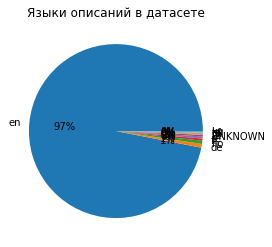

In [78]:
plt.pie(data['language'].value_counts(), autopct='%1.0f%%', labels=data['language'].unique())
plt.title('Языки описаний в датасете')

В описаниях встречаются 10 разных языков, но 97% составляет английский, так что смело отбрасываем остальные

In [32]:
eng_desc = data.loc[data['language'] == 'en']

Все данные для англоязычных описаний скопированы в новый датафрейм, и дальше я буду работать с ним, а исходный датафрейм пригодится во второй части

In [33]:
eng_desc.head(5)

,title,price,rating,total_reviews,product_description,reviews,reviews_rating,Shoe Type,language
0,CLYMB Outdoor Sports Running Shoes for Mens Boy,279.0,2.0,2389,Elevate your style with this classy pair of Ru...,Not happy with product|| It's not as expected....,1.0 out of 5 stars|| 1.0 out of 5 stars|| 3.0 ...,Men,en
1,Bourge Men's Loire-z126 Running Shoes,479.0,3.0,11520,The product will be an excellent pick for you....,Memory cushioning in these shoes is the best f...,5.0 out of 5 stars|| 1.0 out of 5 stars|| 5.0 ...,Men,en
2,T-Rock Men's Sneaker,430.0,3.0,1251,Flaunt with these stylish and unique red casua...,Worth to its amount|| Go for it|| Perfect|| 5 ...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men,en
3,Robbie jones Sneakers Casual Canvas Fabric Col...,499.0,4.0,3,Robbie Jones Shoes Are Designed To Keeping In ...,Sup quality|| Good but not expected|| Awesome 👌.!,5.0 out of 5 stars|| 3.0 out of 5 stars|| 5.0 ...,Men,en
4,Sparx Men's Sd0323g Sneakers,499.0,4.0,20110,Sparx is a spectacular range of footwear from ...,Best|| Satisfied!|| Affordable beauty 😘😘😘😘 the...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men,en


In [34]:
eng_desc.describe()

,price,rating,total_reviews
count,984.000000,984.000000,984.000000
mean,1733.825193,3.544715,802.663618
std,1509.770777,0.575909,3079.186945
min,127.000000,1.000000,1.000000
25%,559.750000,3.000000,27.000000
50%,1339.500000,4.000000,127.000000
75%,2335.500000,4.000000,473.000000
max,7992.000000,5.000000,42193.000000


Встроенной функцией можно изучить только три числовые колонки, но уже отсюда видно, что цена на обувь варьируется от 127 до 7992 рупий со средней ценой в 1733.8 рупий, а ещё большая часть обуви ближе к дешёвой, чем к дорогой (это такая интерпретация второго и третьего квантиля). Средняя оценка обуви, которая правда не требуется для этих задач, составляет всего 3.5 (маловато!). Из отзывов отмечу, что среднее их количество довольно большое, но при этом четверть товаров имеют 27 отзывов или меньше, то есть довольно непопулярны.

In [35]:
eng_desc.corr()

,price,rating,total_reviews
price,1.000000,0.213779,-0.094656
rating,0.213779,1.000000,0.087900
total_reviews,-0.094656,0.087900,1.000000


Можно было бы предположить, что более дорогие товары являются более качественными и поэтому будут получать более хорошие оценки от покупателей, однако в реальности корреляция оказалась довольно слабой. Видимо, к дорогим товарам покупатели предъявляют больше требований и не стремятся оценивать в пять звёзд всё, что не развалилось после первого дождя.  

Дальше проверим, как соотносится мужская и женская обувь и как распределены цены на эти категории:

Text(0.5, 1.0, 'Соотношение мужской и женской обуви')

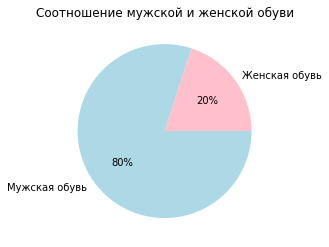

In [36]:
plt.pie([len(eng_desc.loc[eng_desc['Shoe Type'] == 'Women']),
         len(eng_desc.loc[eng_desc['Shoe Type'] == 'Men'])],
         labels=['Женская обувь', 'Мужская обувь'],
         colors=['pink', 'lightblue'],
         autopct='%1.0f%%')
plt.title('Соотношение мужской и женской обуви')

Мужской обуви в датасете сильно больше, при этом в медиане она дороже, максимальная цена принадлежит тоже мужской обуви:

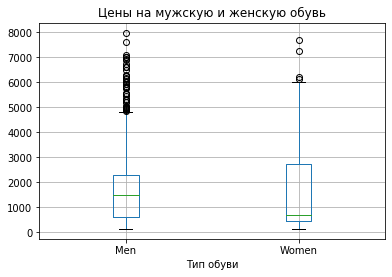

In [37]:
eng_desc.boxplot(['price'], by='Shoe Type')
plt.title('Цены на мужскую и женскую обувь')
plt.suptitle('')
plt.xlabel('Тип обуви')
plt.show()

Посмотрим, как вообще распределяется обувь по ценовым диапазонам: 

In [336]:
x = []
y = []
ranges = list(range(1, 9000, 100))
for i, step in enumerate(ranges[:-1]):
    y.append(len(eng_desc[(eng_desc['price'] > step) & (eng_desc['price'] < ranges[i+1])]))
    x.append(ranges[i+1])

Text(0.5, 1.0, 'Количество обуви в ценовых диапазонах с шагом 100')

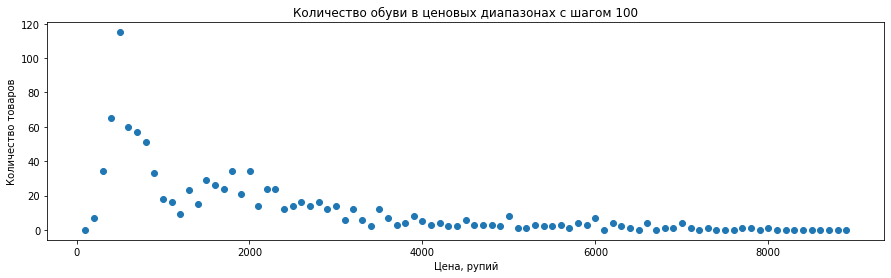

In [338]:
plt.figure(figsize=(15,4))
plt.scatter(x, y)
plt.xlabel('Цена, рупий')
plt.ylabel('Количество товаров')
plt.title('Количество обуви в ценовых диапазонах с шагом 100')

Снова видно, что больше всего обуви находится в диапазонах примерно до 2 000 рупий, что ещё раз подтверждает неравномерное распределение данных  

Дальше посмотрим, что можно понять про описания товаров  

Средняя длина описания в словах. Для скорости и простоты используется сплит по пробелу, а не ворд токенайзер:

In [41]:
desc_lengths = eng_desc['product_description'].str.split().str.len()
np.mean(desc_lengths)

65.33739837398375

Может быть, у продавцов дорогой обуви остаются деньги на копирайтера и длина описания связана с ценой товара?

Text(0.5, 1.0, 'Связь длины описания и цены')

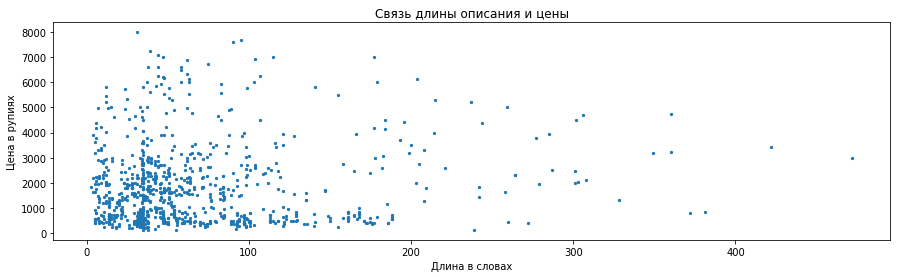

In [335]:
plt.figure(figsize=(15,4))
plt.scatter(desc_lengths, eng_desc['price'], s=5)
plt.xlabel('Длина в словах')
plt.ylabel('Цена в рупиях')
plt.title('Связь длины описания и цены')

Заметно, что несколько самых длинных описаний (больше 200 слов) принадлежат почти исключительно дорогой обуви, однако на массиве всех имеющихся данных корреляция очень слабая:

In [43]:
np.corrcoef(desc_lengths, eng_desc['price'])

array([[1.       , 0.1026057],
       [0.1026057, 1.       ]])

Посмотрим, о чём в целом пишут в наших описаниях:

In [44]:
eng_desc['product_description'][0]

'Elevate your style with this classy pair of Running Shoe from the house of CLYMB brand. Featuring a contemporary refined design with exceptional comfort this pair is perfect to give your quintessential dressing an upgrade.'

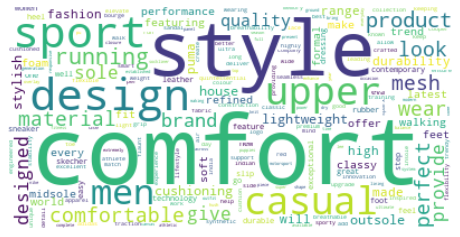

In [45]:
stopwords = set(STOPWORDS)
stopwords.update(['shoes', 'shoe', 'pair', 'footwear'])
text = ' '.join(eng_desc['product_description']).lower()
wordcloud = WordCloud(stopwords=stopwords, background_color="white", collocations=False).generate(text)
plt.figure(figsize=(8,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

В облаке слов главное слово - comfort. Затем продацы часто пишут про тип обуви (sport, casual), описывают её design и style, встречаются также описания отдельных характеристик, например, lightweight и mesh.

И последнее: посмотрим, различаются ли частотные слова в описаниях обуви разной цены. В качестве порога возьмём медианную цену 1399 рупий и сравним вордклауды для более дешёвой и более дорогой половин товаров

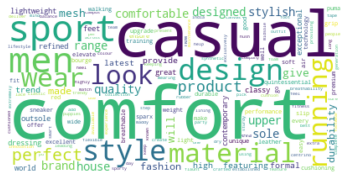

In [49]:
cheap = ' '.join(eng_desc[:int(len(eng_desc)/2)]['product_description']).lower()
wordcloud = WordCloud(stopwords=stopwords, background_color="white", collocations=False).generate(cheap)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

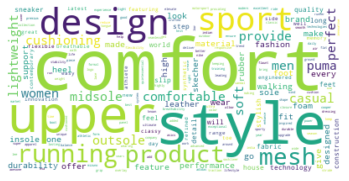

In [50]:
expensive = ' '.join(eng_desc[int(len(eng_desc)/2):]['product_description']).lower()
wordcloud = WordCloud(stopwords=stopwords, background_color="white", collocations=False).generate(expensive)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Интересное наблюдение: слова comfort, design, sport и style частотны в обеих категориях, но в описаниях дешёвой обуви частотно слово casual, а в описаниях дорогой - upper. Более дешёвая обувь, вероятно, предназначена для повседневного ношения, что логично, но не очень понятно, что такое это upper:

In [51]:
eng_desc[eng_desc['product_description'].str.contains('upper')]['product_description'][74]

'Run a few extra miles wearing these sports shoes for men by Goldstar. The synthetic PU (polyurethane) with mesh upper and fabric lining make these lace-ups durable light in weight and comfortable to wear. Not to forget the phylon outsole that further ensures a firm grip to your feet.'

Upper - верх обуви. Возможно, для дорогой обуви чаще описывают материалы, из которых она состоит.

#### Препроцессинг
Препроцессинг, который я выбрала:  
* приведение к нижнему регистру
* удаление стоп-слов
* раскрытие сокращений (can't -> cannot и тд).  
По идее описания должны быть написаны более формальным языком без сокращений, но на всякий случай я это сделаю
* удаление пунктуации, кроме знаков ! и ?
Описания обуви вряд ли будут эмоциональными, но возможно это всё равно поможет
* удаление всех остальных символов, кроме букв и указанной выше пунктуации
* лемматизация того, что осталось

Смысл этого пропроцессинга в том, что я оставляю только леммы значимых слов с маленькой буквы и пунктуацию, отражающую эмоции. Я не беру стемминг, потому что это менее точный способ и он может, например, приводить неоднокоренные слова к одинаковой основе, создавая путаницу.  

Этот препроцессинг ориентирован на английский язык, раньше я уже отбросила всё, что не английский, потому что знаний других языков мне недостаточно, чтобы настроить препроцессинг либо выбрать хороший способ перевода. А пока посмотрим, какие языки вообще есть в датасете:

In [52]:
# одна функция для всего препроцессинга
def preprocess(text):
    doc = nlp(text.lower())
    # spacy сам раскрывает сокращения
    lemmas = [token.lemma_ for token in doc]
    result = [token for token in lemmas if token == '!' or token == '?'
              or (token.isalpha() and token not in STOPWORDS)]
    return result

In [53]:
eng_desc['tokens'] = eng_desc['product_description'].apply(preprocess)
eng_desc.head(5)

,title,price,rating,total_reviews,product_description,reviews,reviews_rating,Shoe Type,language,tokens
0,CLYMB Outdoor Sports Running Shoes for Mens Boy,279.0,2.0,2389,Elevate your style with this classy pair of Ru...,Not happy with product|| It's not as expected....,1.0 out of 5 stars|| 1.0 out of 5 stars|| 3.0 ...,Men,en,"[elevate, style, classy, pair, run, shoe, hous..."
1,Bourge Men's Loire-z126 Running Shoes,479.0,3.0,11520,The product will be an excellent pick for you....,Memory cushioning in these shoes is the best f...,5.0 out of 5 stars|| 1.0 out of 5 stars|| 5.0 ...,Men,en,"[product, will, excellent, pick, ensure, easy,..."
2,T-Rock Men's Sneaker,430.0,3.0,1251,Flaunt with these stylish and unique red casua...,Worth to its amount|| Go for it|| Perfect|| 5 ...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men,en,"[flaunt, stylish, unique, red, casual, shoe, p..."
3,Robbie jones Sneakers Casual Canvas Fabric Col...,499.0,4.0,3,Robbie Jones Shoes Are Designed To Keeping In ...,Sup quality|| Good but not expected|| Awesome 👌.!,5.0 out of 5 stars|| 3.0 out of 5 stars|| 5.0 ...,Men,en,"[robbie, jones, shoe, design, keep, mind, dura..."
4,Sparx Men's Sd0323g Sneakers,499.0,4.0,20110,Sparx is a spectacular range of footwear from ...,Best|| Satisfied!|| Affordable beauty 😘😘😘😘 the...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men,en,"[sparx, spectacular, range, footwear, house, r..."


#### Векторизация

In [245]:
cv_desc = CountVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x)
tfidf_desc = TfidfVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x)

X_cv_desc = cv_desc.fit_transform(eng_desc['tokens'])
X_tfidf_desc = tfidf_desc.fit_transform(eng_desc['tokens'])
y_desc = eng_desc['price'].values

#### Гридсёрч/обучение

In [400]:
ridge = Ridge(fit_intercept = False, random_state=4)
svr = LinearSVR(random_state=4)

Сначала по данным, векторизованным через каунт:

In [423]:
X_cv_train, X_cv_test, y_train, y_test = train_test_split(X_cv_desc, y_desc, random_state=28)

In [424]:
params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
          'solver': ['cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
grid = GridSearchCV(estimator=ridge, param_grid = params, scoring='neg_mean_absolute_error')
grid.fit(X_cv_train, y_train)

print('Best Score: ', grid.best_score_)
print('Best Params: ', grid.best_params_)

Best Score:  -967.997249958994
Best Params:  {'alpha': 10, 'solver': 'cholesky'}


In [425]:
params = {'C': [0.001, 0.01, 0.1, 0.5, 1.0, 10.0],
          'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive']}
grid = GridSearchCV(estimator=svr, param_grid = params, scoring='neg_mean_absolute_error')
grid.fit(X_cv_train, y_train)

print('Best Score: ', grid.best_score_)
print('Best Params: ', grid.best_params_)

Best Score:  -812.242285844178
Best Params:  {'C': 0.01, 'loss': 'squared_epsilon_insensitive'}


Теперь то же самое по tf-idf:

In [426]:
X_tfidf_train, X_tfidf_test, y_train, y_test = train_test_split(X_tfidf_desc, y_desc, random_state=28)

In [427]:
params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
          'solver': ['cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
grid = GridSearchCV(estimator=ridge, param_grid = params, scoring='neg_mean_absolute_error')
grid.fit(X_tfidf_train, y_train)

print('Best Score: ', grid.best_score_)
print('Best Params: ', grid.best_params_)

Best Score:  -788.6090255054071
Best Params:  {'alpha': 0.1, 'solver': 'saga'}


In [428]:
params = {'C': [0.001, 0.01, 0.1, 0.5, 1.0, 10.0],
          'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive']}
grid = GridSearchCV(estimator=svr, param_grid = params, scoring='neg_mean_absolute_error')
grid.fit(X_tfidf_train, y_train)

print('Best Score: ', grid.best_score_)
print('Best Params: ', grid.best_params_)

Best Score:  -758.7498215797681
Best Params:  {'C': 1.0, 'loss': 'squared_epsilon_insensitive'}


Лучший результат показала модель linear svr с гиперпараметрами C = 1.0 и функцией потерь squared epsilon insensitive на данных, векторизованных tf-idf. Честно говоря, я так и не смогла разобраться, чем линейная SVR отличается от обычной линейной регрессии и в чём могут быть её преимущества на этих данных.  

Однако ошибка всё равно довольно большая - 758.7 рупий. Подозреваю, что виной этому выбросы в данных - редкие очень дорогие туфли. Можно было бы повторить эксперимент, отрезав эти выбросы, но повышение точности модели уже выходит за рамки этого задания.

#### Анализ
Теперь проверим лучшую модель на тестовой выборке:

In [429]:
best_params = {'C': 1.0,
               'loss': 'squared_epsilon_insensitive'}
best_svr = LinearSVR(**best_params)
best_svr.fit(X_tfidf_train, y_train)

y_pred = best_svr.predict(X_test)

In [430]:
MAE = mean_absolute_error(y_test, y_pred)
MAE

647.7470208078358

Значение средней абсолютной ошибки оказалось даже ниже на тестовой выборке, чем на обучающей. Посмотрим визуально, насколько предсказания отличаются от правды:

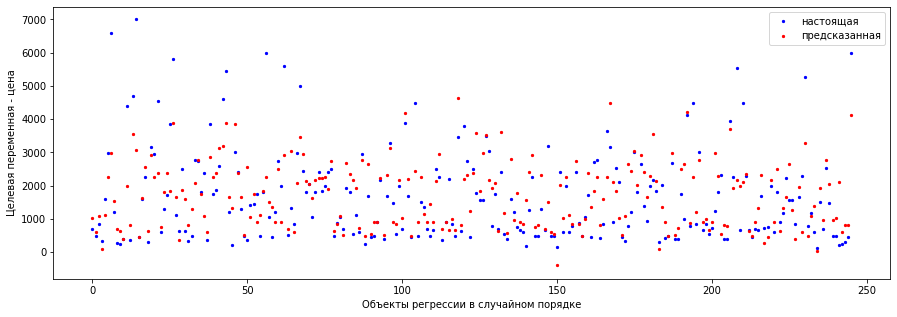

In [431]:
plt.figure(figsize=(15,5))
plt.scatter(range(len(y_test)), y_test, s=5, color='blue', label='настоящая')
plt.scatter(range(len(y_pred)), y_pred, s=5, color='red', label='предсказанная')
plt.xlabel('Объекты регрессии в случайном порядке')
plt.ylabel('Целевая переменная - цена')
plt.legend()
plt.show()

Визуально можно сказать, что на объектах с низкими ценами модель ошибается не так сильно, в диапазоне примерно до 1 000 рупий довольно много точек, которые стоят очень близко и даже накладываются. Однако чем выше цена (и меньше объектов по такой цене), тем больше оказывается разброс между предсказаниями и правдой:

Text(0, 0.5, 'Модуль ошибки')

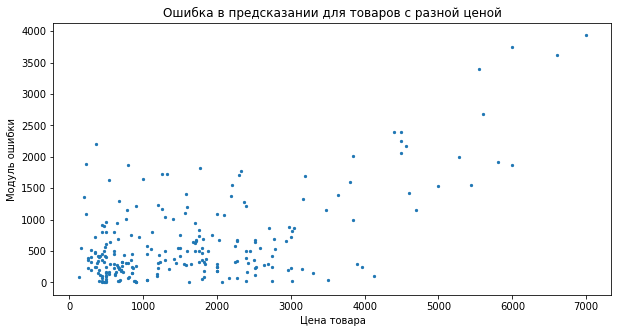

In [433]:
plt.figure(figsize=(10,5))
plt.scatter(y_test, [np.sqrt((test-pred)**2) for test, pred in zip(y_test,y_pred)],
           s=5)
plt.title('Ошибка в предсказании для товаров с разной ценой')
plt.xlabel('Цена товара')
plt.ylabel('Модуль ошибки')

Также стоит отметить, что встретилось даже одно отрицательное предсказание (а в предыдущей итерации их было даже около 10), чего не должно быть, ведь все цены в датасете по определению больше нуля.  

Для более точного результата надо либо собрать/сгенерировать больше данных про дорогую обувь, либо отбросить данные про неё, потому что модель лучше справляется с тем, про что данных много. Ещё можно добавить дополнительные фичи, как текстовые, например, длину описания или типичные н-граммы в описаниях обуви разных ценовых категорий, так и нетекстовые, такие как вид обуви, средняя оценка и тд. 

### Часть 2. Предсказать оценку по отзыву
Возвращаемся к датафрейму

In [62]:
data.head(5)

,title,price,rating,total_reviews,product_description,reviews,reviews_rating,Shoe Type,language
0,CLYMB Outdoor Sports Running Shoes for Mens Boy,279.0,2.0,2389,Elevate your style with this classy pair of Ru...,Not happy with product|| It's not as expected....,1.0 out of 5 stars|| 1.0 out of 5 stars|| 3.0 ...,Men,en
1,Bourge Men's Loire-z126 Running Shoes,479.0,3.0,11520,The product will be an excellent pick for you....,Memory cushioning in these shoes is the best f...,5.0 out of 5 stars|| 1.0 out of 5 stars|| 5.0 ...,Men,en
2,T-Rock Men's Sneaker,430.0,3.0,1251,Flaunt with these stylish and unique red casua...,Worth to its amount|| Go for it|| Perfect|| 5 ...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men,en
3,Robbie jones Sneakers Casual Canvas Fabric Col...,499.0,4.0,3,Robbie Jones Shoes Are Designed To Keeping In ...,Sup quality|| Good but not expected|| Awesome 👌.!,5.0 out of 5 stars|| 3.0 out of 5 stars|| 5.0 ...,Men,en
4,Sparx Men's Sd0323g Sneakers,499.0,4.0,20110,Sparx is a spectacular range of footwear from ...,Best|| Satisfied!|| Affordable beauty 😘😘😘😘 the...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men,en


In [63]:
reviews = data['reviews'].to_list()
reviews_rating  = data['reviews_rating'].to_list()

In [73]:
# компактно, но нечитаемо:
# sep_reviews = [item for review in reviews for item in review.split('|| ')]

sep_reviews = []
for review in reviews:
    for item in review.split('|| '):
        sep_reviews.append(item)

sep_rev_ratings = []
for rating in reviews_rating:
    for item in rating.split('|| '):
        # нужна только первая цифра
        sep_rev_ratings.append(int(item[0]))
        
len(sep_reviews) == len(sep_rev_ratings)

True

In [68]:
rews = pd.DataFrame(list(zip(sep_reviews, sep_rev_ratings)),
                      columns =['review', 'rating'])
rews.head(5)

,review,rating
0,Not happy with product,1
1,It's not as expected.,1
2,AVERAGE PRODUCT,3
3,Pic more beautiful,3
4,Got damage product. But quality is average for...,3


#### Анализ данных

In [69]:
rews.shape

(8208, 2)

Всего у нас есть 8 208 отзывов. Здесь мы тоже сначала посмотрим, какие есть языки. Однако есть проблема: из-за того, что что отзывы часто короткие, определение языка от spacy и от langdetect (часть с ним я удалила, чтобы не дублировать всё тоже самое) даёт одинаковые ответы и ошибается слишком часто:

In [81]:
rews['language'] = rews['review'].apply(detect_lang)

In [82]:
print(rews['language'].unique())

['en' 'tl' 'ro' 'no' 'et' 'sv' 'ca' 'af' 'de' 'cy' 'so' 'id' 'nl' 'it'
 'tr' 'sq' 'pl' 'es' 'da' 'fr' 'cs' 'hi' 'sl' 'pt' 'lv' 'sw' 'UNKNOWN'
 'mr' 'vi' 'hr' 'sk' 'fi' 'hu' 'lt' 'ta']


Text(0.5, 1.0, 'Языки отзывов')

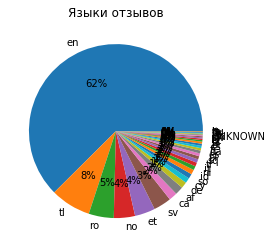

In [83]:
plt.pie(rews['language'].value_counts(), autopct='%1.0f%%', labels=rews['language'].unique())
plt.title('Языки отзывов')

In [85]:
rews.loc[rews['language'] == 'tl']

,review,rating,language
2,AVERAGE PRODUCT,3,tl
7,Don't buy,2,tl
9,Do not buy it anyway,1,tl
28,No buy,1,tl
138,Pasting not good,3,tl
...,...,...,...
7547,Fitting not like bata,1,tl
7639,Too 'noisy',2,tl
7945,okay,4,tl
8120,PERFECT IN ALL CONDITION,5,tl


Я не хочу терять много данных, поэтому для отзывов сделаю более простую функцию, которая опирается на наличие символов латиницы. Здесь я делаю выбор в пользу случайного захвата данных на неанглийском языке, чем потери данных на английском

In [122]:
def detect_updated(text):
    if len(set(text) & set(ascii_letters)) == 0:
        return 'non-en'
    return 'en'

In [123]:
rews['language'] = rews['review'].apply(detect_updated)

Text(0.5, 1.0, 'Языки отзывов')

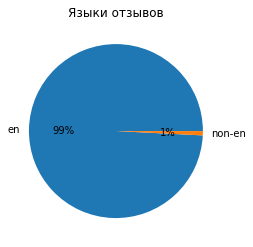

In [124]:
plt.pie(rews['language'].value_counts(), autopct='%1.0f%%', labels=rews['language'].unique())
plt.title('Языки отзывов')

In [125]:
rews.loc[rews['language'] == 'non-en']

,review,rating,language
212,बहुत ही खराब सामान,2,non-en
349,5*,5,non-en
402,सुझाव,2,non-en
583,👎🏻,1,non-en
585,⭐️⭐️⭐️⭐️⭐️,5,non-en
...,...,...,...
7383,😍,5,non-en
7830,👍👍👍,5,non-en
7965,😍😍,5,non-en
8045,.,5,non-en


Этот способ выкидывает заодно смайлики, но они бы всё равно откинулись дальше на препроцессинге, потому что мы учимся определять всё-таки по словам, а не по рисункам

In [126]:
eng_rews = rews.loc[rews['language'] == 'en']

In [127]:
eng_rews.describe()

,rating
count,8143.000000
mean,3.708952
std,1.547108
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


Средняя оценка от покупателя здесь составила 3.7, минимум и максимум очевидно 1 и 5, квартили красиво распределились по оценкам 3, 4 и 5 соответственно  
Посмотрим, сколько каких оценок у нас есть:

Text(0.5, 1.0, 'Распределение оценок')

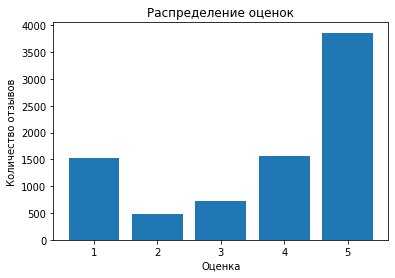

In [145]:
x = sorted(eng_rews['rating'].unique())
y = [eng_rews['rating'].value_counts()[mark] for mark in x]
plt.bar(x, y)
plt.xlabel('Оценка')
plt.ylabel('Количество отзывов')
plt.title('Распределение оценок')

Пятёрок больше всего, затем идут четвёрки и единицы, и потом уже два и три. Здесь данные тоже немного несбалансированы, потому что почти половина всех отзывов - положительные на 5 баллов  

Теперь посмотрим на тексты отзывов

In [146]:
rew_lengths = eng_rews['review'].str.split().str.len()
np.mean(rew_lengths)

3.6999877195136928

Средняя длина отзыва всего 3,6 слова. Посмотрим, какая длина у отзывов с разной оценкой:

In [166]:
y = []
for mark in eng_rews['rating'].unique():
    lengths = eng_rews.loc[eng_rews['rating'] == mark]['review'].str.split().str.len()
    y.append(np.mean(lengths))

Text(0.5, 1.0, 'Связь длины отзыва и оценки')

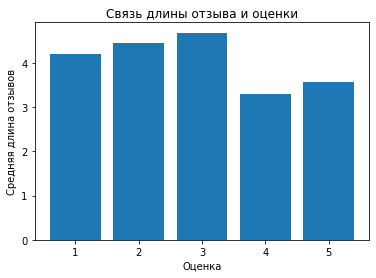

In [170]:
plt.bar(x, y)
plt.xlabel('Оценка')
plt.ylabel('Средняя длина отзывов')
plt.title('Связь длины отзыва и оценки')

Плохие отзывы в среднем длиннее, чем хорошие. Можно предположить, что пользователи описывают недостатки подробнее, чем достоинства

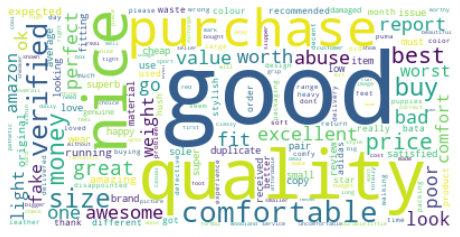

In [172]:
stopwords = set(STOPWORDS)
stopwords.update(['shoes', 'shoe', 'product'])
text = ' '.join(eng_rews['review']).lower()
wordcloud = WordCloud(stopwords=stopwords, background_color="white", collocations=False).generate(text)
plt.figure(figsize=(8,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

В облаке слов самые популярные слова имеют положительную окраску: good, nice, comfortable. Неудивительно, ведь половина отзывов у нас на пятёрку. Проверим только отрицательные отзывы:

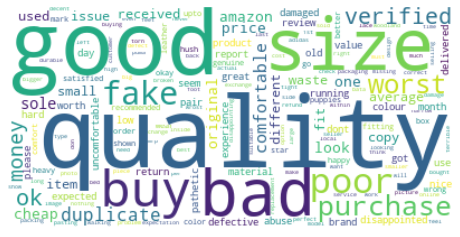

In [181]:
text = ' '.join(eng_rews.loc[eng_rews['rating'].isin([1, 2, 3])]['review']).lower()
wordcloud = WordCloud(stopwords=stopwords, background_color="white", collocations=False).generate(text)
plt.figure(figsize=(8,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Quality, good, buy - скорее всего, части словосочетаний not good, poor quality, don't buy. Size, fake, poor - похоже, покупатели часто жалуются на подделки, плохое качество и несоответствие размеров. Здесь я сразу на будущее удалю not из стоп-слов, потому что оно как раз важно для определения оценки по тексту, т.к. может указывать на полярность

In [219]:
STOPWORDS.remove('not')

#### Препроцессинг

In [220]:
eng_rews['tokens'] = eng_rews['review'].apply(preprocess)
eng_rews.head(5)

,review,rating,language,tokens
0,Not happy with product,1,en,"[not, happy, product]"
1,It's not as expected.,1,en,"[not, expect]"
2,AVERAGE PRODUCT,3,en,"[average, product]"
3,Pic more beautiful,3,en,"[pic, much, beautiful]"
4,Got damage product. But quality is average for...,3,en,"[damage, product, quality, average]"


#### Векторизация

In [222]:
cv_rews = CountVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x)
tfidf_rews = TfidfVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x)

X_cv_rews = cv_rews.fit_transform(eng_rews['tokens'])
X_tfidf_rews = tfidf_rews.fit_transform(eng_rews['tokens'])
y_rews = eng_rews['rating'].values

#### Гридсёрч/обучение
Снова сначала на векторах BoW:

In [434]:
X_cv_train, X_cv_test, y_train, y_test = train_test_split(X_cv_rews, y_rews, random_state=28)

In [435]:
logreg = LogisticRegression(random_state=4)
knc = KNeighborsClassifier()

In [436]:
params = {'class_weight' : ['balanced', None],
          'penalty' : ['l2', 'l1'],
          'solver' : ['liblinear', 'saga'],
          'C' : [0.001, 0.01, 0.1, 0.5, 1.0, 10.0, 100.0]}
grid = GridSearchCV(logreg, param_grid=params, scoring='accuracy')
grid.fit(X_cv_train, y_train)

print('Best Score: ', grid.best_score_)
print('Best Params: ', grid.best_params_)

Best Score:  0.6287866382839364
Best Params:  {'C': 1.0, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}


In [437]:
params = {'n_neighbors': [2, 3, 5, 10, 20, 30],
          'algorithm': ['ball_tree', 'kd_tree', 'brute'],
          'weights': ['uniform', 'distance']}
grid = GridSearchCV(knc, param_grid=params, scoring='accuracy')
grid.fit(X_cv_train, y_train)

print('Best Score: ', grid.best_score_)
print('Best Params: ', grid.best_params_)

Best Score:  0.6074995906336991
Best Params:  {'algorithm': 'ball_tree', 'n_neighbors': 30, 'weights': 'distance'}


Затем на векторах tf-idf:

In [438]:
X_tfidf_train, X_tfidf_test, y_train, y_test = train_test_split(X_tfidf_rews, y_rews, random_state=28)

In [440]:
params = {'class_weight' : ['balanced', None],
          'penalty' : ['l2', 'l1'],
          'solver' : ['liblinear', 'saga'],
          'C' : [0.001, 0.01, 0.1, 0.5, 1.0, 10.0, 100.0]}
grid = GridSearchCV(logreg, param_grid=params, scoring='accuracy')
grid.fit(X_tfidf_train, y_train)

print('Best Score: ', grid.best_score_)
print('Best Params: ', grid.best_params_)

Best Score:  0.6228917635500245
Best Params:  {'C': 10.0, 'class_weight': None, 'penalty': 'l2', 'solver': 'saga'}


In [441]:
params = {'n_neighbors': [2, 3, 5, 10, 20, 30],
          'algorithm': ['ball_tree', 'kd_tree', 'brute'],
          'weights': ['uniform', 'distance']}
grid = GridSearchCV(knc, param_grid=params, scoring='accuracy')
grid.fit(X_tfidf_train, y_train)

print('Best Score: ', grid.best_score_)
print('Best Params: ', grid.best_params_)

Best Score:  0.5960373342066481
Best Params:  {'algorithm': 'ball_tree', 'n_neighbors': 30, 'weights': 'distance'}


Здесь лучшей моделью оказалась логистическая регрессия на векторах BoW с параметрами C = 1.0, class_weight = None, penalty = l2, solver = liblinear. Преимущество BoW довольно неожиданное, кажется, что tf-idf - более "качественный" способ, потому что учитывает не просто наличие слов, но и их важность. Однако разница между моделями оказалась всего 0,00589 и при новом запуске моделей или при выборе другой метрики для гридсёрча результат мог бы чуть поменяться, и перевесила бы уже другая модель, поэтому заявлять о существенном преимуществе данных каунт векторайзера тут не стоит. Скорее всего, это случайность.  

На обоих видах данных knс справляется хуже логистической регрессии. Предполагаю, потому, что он опирается на ближайших соседей, а в наших данных это не очень надёжный вариант, потому что отзывы с соседними оценками не обязательно содержат в тексте все причины своих оценок. Покупатель написал то, что кажется ему наиболее важным, но оценку он выбирает исходя из общего своего впечатления о товаре, а не только из тех нескольких деталей, которые он вынес в текстовый отзыв. Другими словами, разница между разными оценками, особенно близкими, не обязательно отражается в тексте

#### Анализ
Предсказание лучшей моделью на тестовых данных:

In [447]:
best_params = {'C': 1.0, 'class_weight': None,
               'penalty': 'l2', 'solver': 'liblinear'}
best_classif = LogisticRegression(**best_params)
best_classif.fit(X_cv_train, y_train)

y_pred = best_classif.predict(X_cv_test)

Посмотрим подробнее на разные метрики:

In [448]:
acc = accuracy_score(y_test, y_pred)
micro_f1 = f1_score(y_test, y_pred, average = 'micro')
micro_p = precision_score(y_test, y_pred, average = 'micro')
micro_r = recall_score(y_test, y_pred, average = 'micro')
macro_f1 = f1_score(y_test, y_pred, average = 'macro')
macro_p = precision_score(y_test, y_pred, average = 'macro')
macro_r = recall_score(y_test, y_pred, average = 'macro')
print('acc={0:1.4f}'.format(acc))
print('micro F1={0:1.4f}, micro P={1:1.4f}, micro R={2:1.4f}'.format(micro_f1, micro_p, micro_r))
print('macro F1={0:1.4f}, macro P={1:1.4f}, macro R={2:1.4f}\n'.format(macro_f1, macro_p, macro_r))

acc=0.6316
micro F1=0.6316, micro P=0.6316, micro R=0.6316
macro F1=0.4074, macro P=0.5012, macro R=0.4143



На тестовом корпусе доля верных ответов оказалась даже немного выше, чем на тренировочном. Возможно, это случайность, связанная с разделением данных на трейн и тест, и если запустить несколько повторений обучения и предсказания на по-разному поделённых данных, то средний результат будет другой.  

Макро скоры - среднее скоров по всем классам - довольно низкие, при этом полнота ниже, чем точность. Однако эти скоры не говорят нам ничего о том, какие именно классы определяются хуже, какие чаще путаются. В условии не сказано, для чего нам нужно определять оценку по тексту отзыва, однако могу предположить, что перепутать отзывы на 1 балл и на 5 всегда будет более серьёзной ошибкой, чем перепутать отзывы на 1 и 2 балла.  

Чтобы подробнее посмотреть на каждый класс, построим матрицу ошибок:

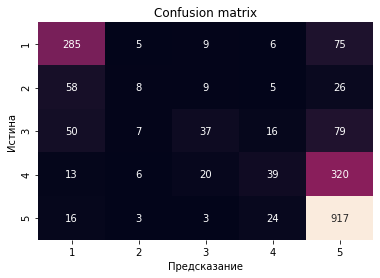

In [449]:
sns.heatmap(data=confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            cbar=False, xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.title('Confusion matrix')
plt.xlabel('Предсказание')
plt.ylabel('Истина')
plt.show()

По этой матрице видно, что лучше всего классификатор определяет сильно отрицательные (1) и сильно положительные (5) отзывы, а больше всего путает две группы положительных, принимая отзывы с оценкой 4 за отзывы с оценкой 5. Довольно логично, что самые полярные отзывы определяются лучше всего, потому что в таких крайних точках недовольства или удовлетворения покупатели наверняка используют больше эмоционально окрашенных слов, что позволяет классификатору точнее определять именно эти группы.  

А ещё в датасете отзывов на 1 и на 5 было больше остальных, что и помогает лучше их определять, и делает более заметными на матрице. Я решила нормализовать абсолютные величины, чтобы посмотреть на результат для каждого класса независимо от его размера:

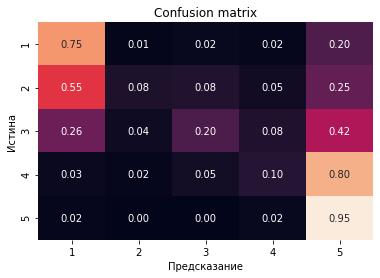

In [450]:
cm = confusion_matrix(y_test, y_pred)
cmn = cm.astype('float') / cm.sum(axis=-1)[:, np.newaxis]
sns.heatmap(data=cmn, annot=True, fmt='.2f',
            cbar=False, xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.title('Confusion matrix')
plt.xlabel('Предсказание')
plt.ylabel('Истина')
plt.show()

Теперь каждый истинный класс составляет 1.0 и их можно сравнивать между собой. Лучше всего определены отзывы на пятёрку - 95% были найдены верно. Затем отзывы на единицу с 75% полноты. Отзывы на 2, 3 и 4 балла были распознаны всего в 8, 20 и 10 процентах соответственно.  

Также на нормированной матрице стало хорошо видно ошибки в распознавании "промежуточных" отзывов на 2, 3 и 4 балла. Отзывы на двойку в 55% принимались за более плохие отзывы на единицу. Тройки принимались в 42% за пятёрки, а четвёрки аж в 80% за пятёрки. Заметно, что классификатор не только лучше распознаёт отзывы на 1 и 5, но и остальные отзывы тоже склонен распознавать как 1 и 5 вместо промежуточных классов.  

Чтобы улучшить классификацию и подтянуть распознавание "средних" отзывов, можно сгладить несбалансированность данных, то есть либо добавить данных про средние отзывы, либо обрезать избыточные данные про категории 1 и 5. Однако я не уверена, что это полностью поможет, потому что полярные отзывы скорее всего более эмоциональны и поэтому распознавать их проще, даже если мы сбалансируем данные или будем дополнительно штрафовать за ошибки в классах 2-3-4.